In [6]:
import pickle

# dict {video_keys:tupel()}
active_videos = pickle.load(open('./data/active-dataset.p', 'rb'))


In [7]:
test_vid = 'X0ZEt_GZfkA'
daily_share, daily_view, daily_watch = active_videos[test_vid]

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf
from scipy.fft import fft, fftfreq

def analyze_periodicity(series, name='Series', sampling_interval=1):
    """
    Analyze periodicity of a time series using time plot, ACF and FFT.

    :param series: 1D array-like, time series data
    :param name: str, name of the series for labeling
    :param sampling_interval: float, time interval between samples (default: 1 day)
    """
    n = len(series)
    fig, axes = plt.subplots(3, 1, figsize=(12, 10))

    # Time Series Plot
    axes[0].plot(series, label=f'Daily {name}', color='tab:blue')
    axes[0].set_title(f'{name} - Time Series')
    axes[0].set_xlabel('Day')
    axes[0].set_ylabel(name)
    axes[0].legend()
    axes[0].grid(True)

    # Autocorrelation Plot
    acf_vals = acf(series, nlags=30)
    axes[1].stem(range(len(acf_vals)), acf_vals, use_line_collection=True)
    axes[1].set_title(f'{name} - Autocorrelation (ACF)')
    axes[1].set_xlabel('Lag (days)')
    axes[1].set_ylabel('ACF')
    axes[1].grid(True)

    # FFT Frequency Spectrum
    freq = fftfreq(n, d=sampling_interval)
    fft_vals = np.abs(fft(series))
    axes[2].plot(freq[:n // 2], fft_vals[:n // 2], color='tab:green')
    axes[2].set_title(f'{name} - Frequency Spectrum (FFT)')
    axes[2].set_xlabel('Frequency (1/day)')
    axes[2].set_ylabel('Amplitude')
    axes[2].grid(True)

    plt.tight_layout()
    plt.show()




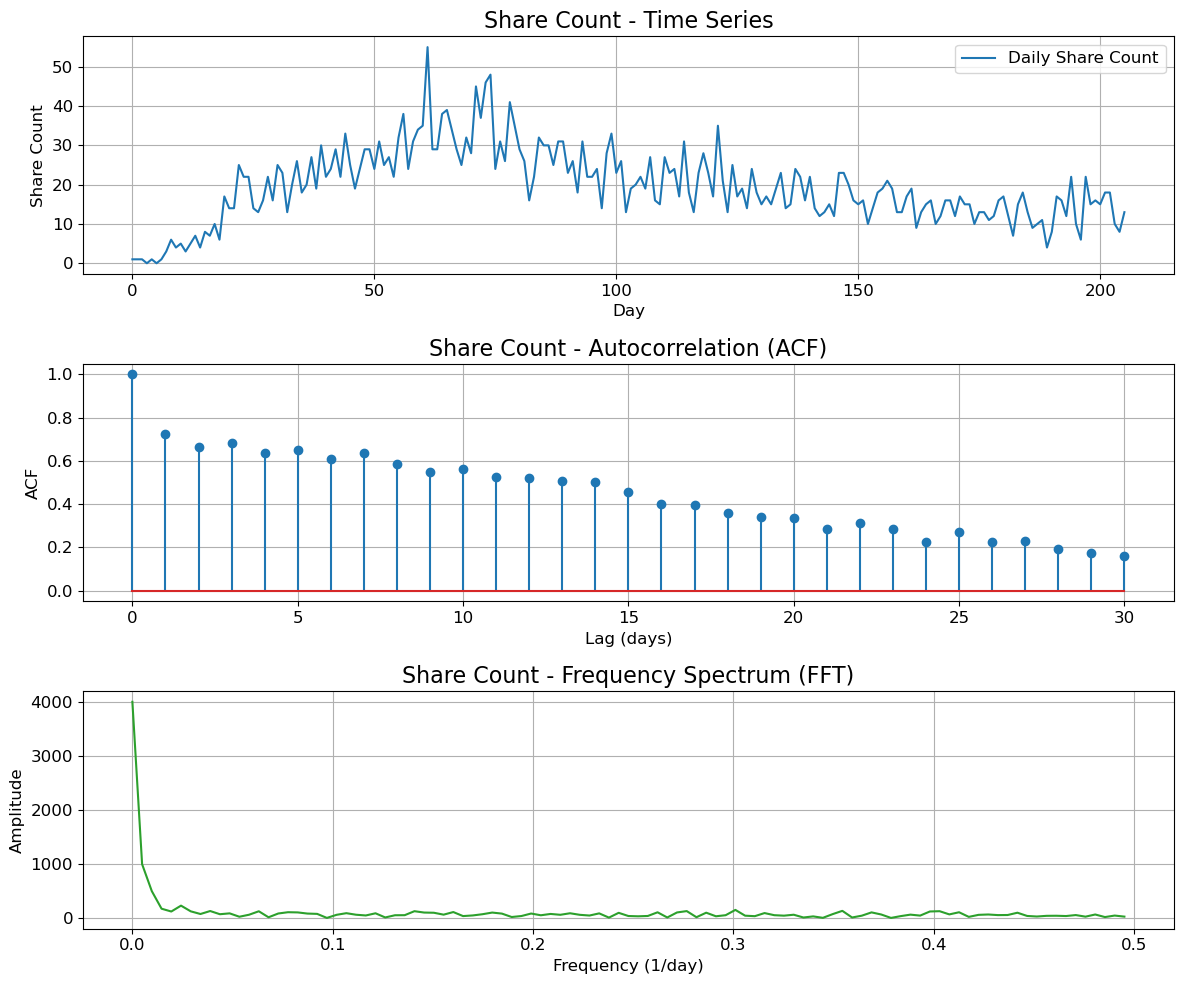

In [9]:
# Example usage (replace with your actual data)
# daily_share, daily_view, _ = active_videos[test_vid]
analyze_periodicity(daily_share, name='Share Count')


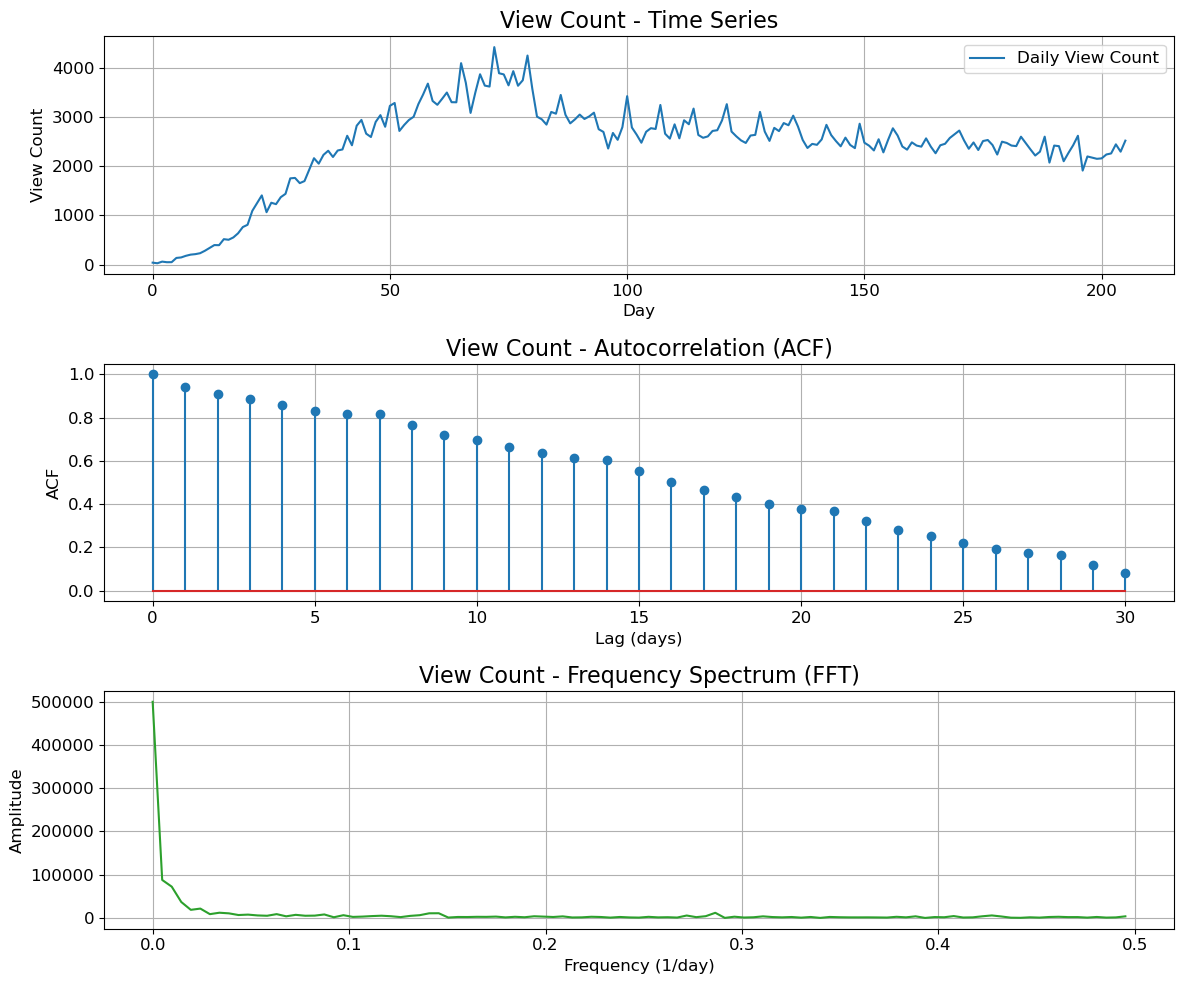

In [10]:
analyze_periodicity(daily_view, name='View Count')

In [11]:
import numpy as np
from scipy.stats import pearsonr

corr, p_value = pearsonr(daily_share, daily_view)
print(f"Pearson correlation: {corr:.3f}, p-value: {p_value:.3g}")


Pearson correlation: 0.736, p-value: 2.06e-36


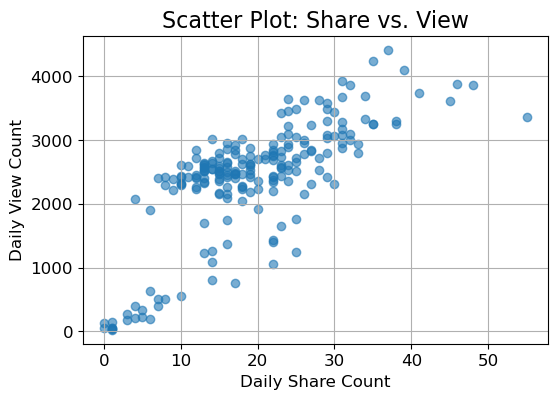

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.scatter(daily_share, daily_view, alpha=0.6)
plt.xlabel('Daily Share Count')
plt.ylabel('Daily View Count')
plt.title('Scatter Plot: Share vs. View')
plt.grid(True)
plt.show()


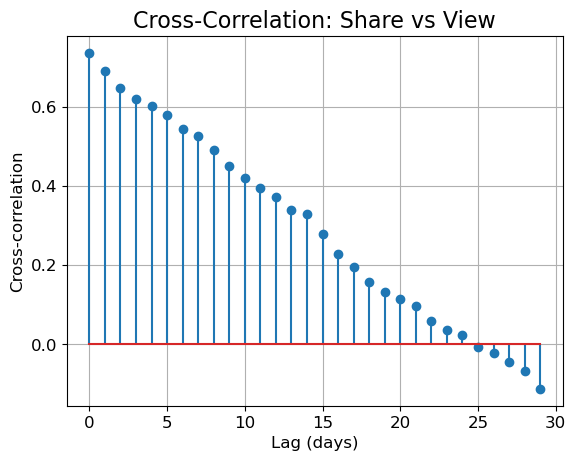

In [13]:
from statsmodels.tsa.stattools import ccf

lags = np.arange(0, 30)
ccf_vals = ccf(daily_share, daily_view)[:30]

plt.stem(lags, ccf_vals, use_line_collection=True)
plt.xlabel('Lag (days)')
plt.ylabel('Cross-correlation')
plt.title('Cross-Correlation: Share vs View')
plt.grid(True)
plt.show()


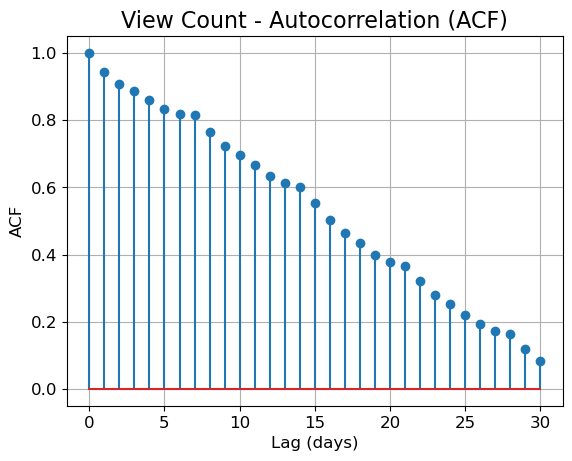

In [14]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf

def plot_daily_view_acf(series, nlags=30):
    acf_vals = acf(series, nlags=nlags)
    plt.stem(range(len(acf_vals)), acf_vals, use_line_collection=True)
    plt.title(f'View Count - Autocorrelation (ACF)')
    plt.xlabel('Lag (days)')
    plt.ylabel('ACF')
    plt.grid(True)

# 调用函数
plot_daily_view_acf(daily_view)


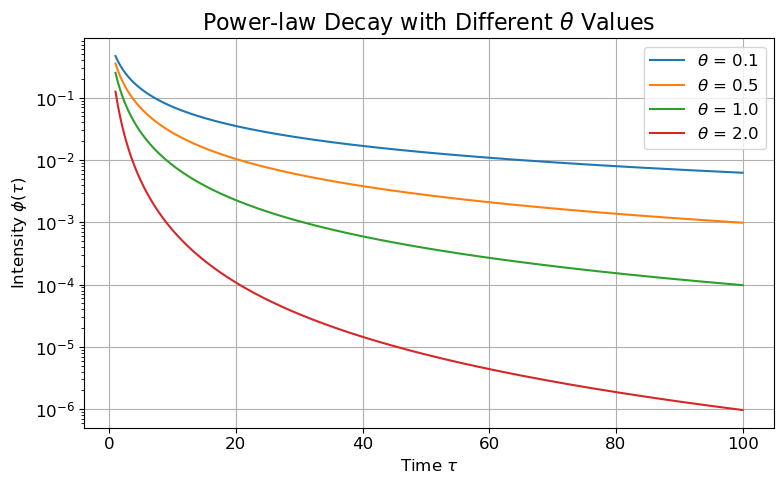

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# 设置时间范围（τ）
t = np.linspace(1, 100, 500)  # 避免 t=0
c = 1  # 平滑项，防止除以 0

# 设置不同的幂次 theta
theta_values = [0.1, 0.5, 1.0, 2.0]

# 绘图
plt.figure(figsize=(8, 5))

for theta in theta_values:
    y = 1 / (t + c) ** (1 + theta)
    plt.plot(t, y, label=f'$\\theta$ = {theta}')

plt.title('Power-law Decay with Different $\\theta$ Values')
plt.xlabel('Time $\\tau$')
plt.ylabel('Intensity $\\phi(\\tau)$')
plt.yscale('log')  # 常用于展示衰减过程
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [21]:
def plot_forecasts(result_dict, title=None):
    y_true = result_dict["true"]
    arimax_pred = result_dict["arimax_pred"]
    hip_pred = result_dict["hip_pred"]
    days = np.arange(len(y_true))

    plt.figure(figsize=(10, 5))
    plt.plot(days, y_true, label="True Views", color="black", linewidth=2)
    plt.plot(days, arimax_pred, label=f"ARIMAX (RMSE={result_dict['arimax_rmse']:.2f})", linestyle="--")
    plt.plot(days, hip_pred, label=f"HIP (RMSE={result_dict['hip_rmse']:.2f})", linestyle=":")
    plt.xlabel("Test Day")
    plt.ylabel("Daily Views")
    plt.title(title or f"Forecast Comparison for Video {result_dict['video']}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [22]:
import random

n_sample = 10

results = {}
selected_ids = random.sample(list(active_videos.keys()), n_sample)

arima_rmses = []
hip_rmses = []

for vid in selected_ids:
    try:
        daily_share, daily_view, _ = active_videos[vid]

        arima_rmse, _ = arimax_forecast_fixed_split(daily_view, daily_share, num_train, num_test)
        hip_rmse, _ = hip_forecast(daily_share, daily_view, num_train, num_test)

        arima_rmses.append(arima_rmse)
        hip_rmses.append(hip_rmse)

        results[vid] = {
            'arima_rmse': arima_rmse,
            'hip_rmse': hip_rmse
        }
        print(f'-------------{vid}-------------')
        print(f"[ARIMAX] RMSE: {arima_rmse:.4f}")
        print(f"[HIP] RMSE: {hip_rmse:.4f}")
    except Exception as e:
        print(f"Error processing video {vid}: {e}")

results['avg_arima_rmse'] = np.mean(arima_rmses)
results['avg_hip_rmse'] = np.mean(hip_rmses)

-------------X9MCBQVVKwM-------------
[ARIMAX] RMSE: 214.4533
[HIP] RMSE: 8.9365
Error processing video 1M3FUqGqQdE: arange: cannot compute length


KeyboardInterrupt: 

========== Case Study for Video: 9AhSbOTUkSM ==========


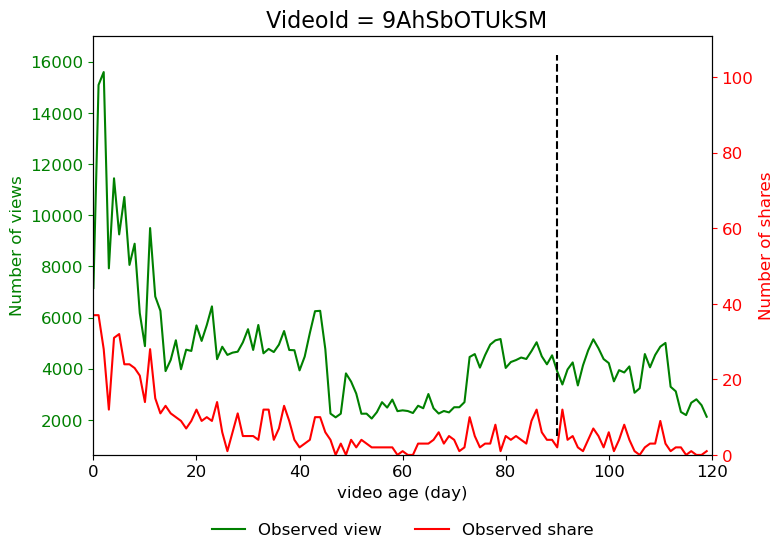

In [6]:
from comparison import *

active_videos = pickle.load(open('./data/active-dataset.p', 'rb'))
num_train = 90
num_test = 30

case_study(data_source=active_videos, video_id='9AhSbOTUkSM', num_train=num_train, num_test=num_test)

========== Case Study for Video: X0ZEt_GZfkA ==========


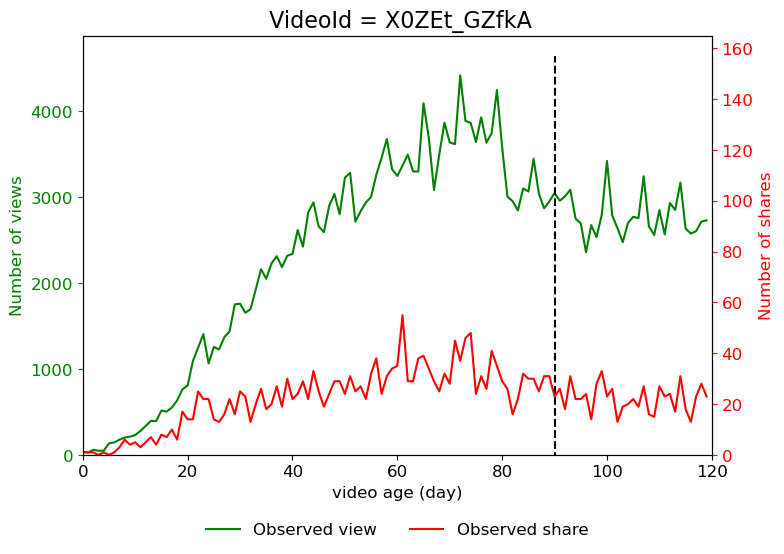

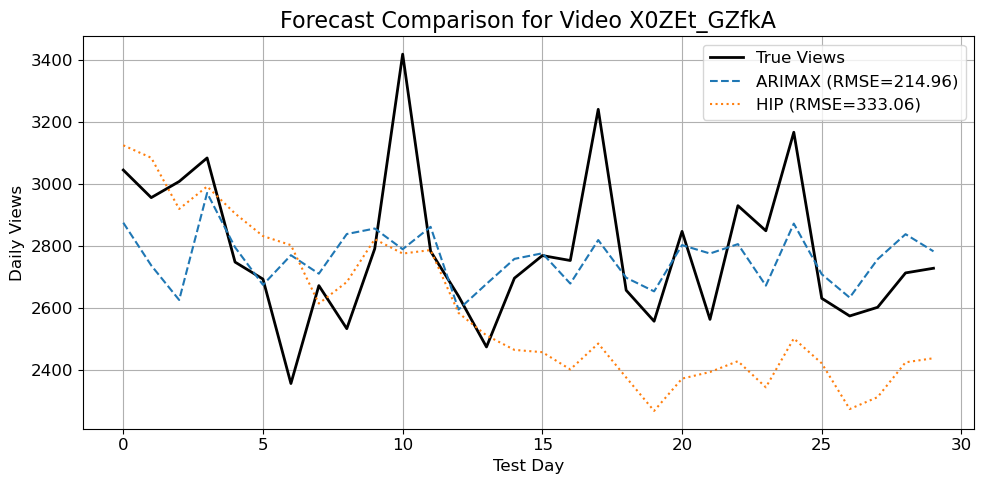

[ARIMAX] RMSE: 214.9592
[HIP   ] RMSE: 333.0585


In [14]:
case_study(data_source=active_videos, video_id='X0ZEt_GZfkA', num_train=num_train, num_test=num_test,plot_predictions=True)


[init=1] HIP RMSE: 559.4576
[init=5] HIP RMSE: 361.1290
[init=10] HIP RMSE: 296.6443
[init=20] HIP RMSE: 275.8172
[init=25] HIP RMSE: 277.2639


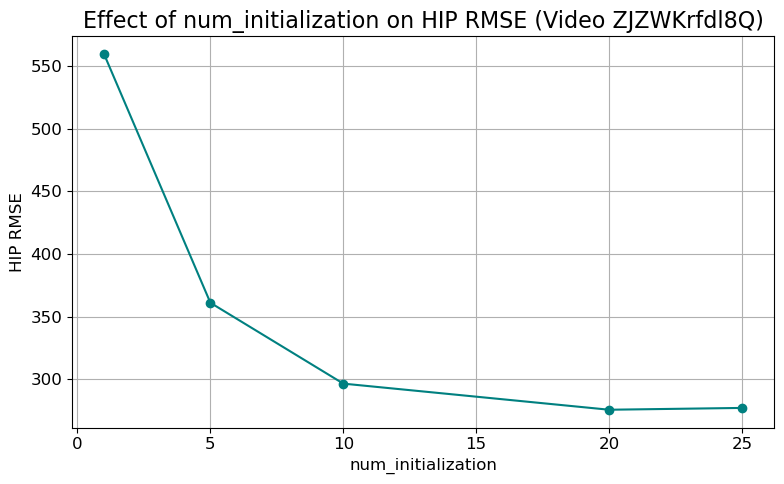

{1: 559.4575966180007,
 5: 361.12900407419505,
 10: 296.64431880663483,
 20: 275.81721461891266,
 25: 277.2639152847283}

In [16]:
from comparison import *
active_videos = pickle.load(open('./data/active-dataset.p', 'rb'))

cmp = Comparison(data_source=active_videos, video_id='ZJZWKrfdl8Q', num_train=90, num_test=30)
cmp.test_initialization_effect(init_list=[1,5,10,20,25])
